In [1]:

import pandas as pd
import numpy as np
import pywt
import pandas as pd 
from scipy.stats import skew, kurtosis, median_abs_deviation, moment
import math 
import scipy
import matplotlib.pyplot as plt 
import pywt
import pandas as pd 
import copy
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import lime
from lime import lime_tabular

2024-08-29 03:53:06.462703: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 03:53:06.706992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 03:53:06.818890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 03:53:06.851239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 03:53:07.030604: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def rmsValue(array):
    n = len(array)
    squre = 0.0
    root = 0.0
    mean = 0.0
    for i in range(0, n):
        squre += (array[i] ** 2)
    mean = (squre/ (float)(n))
    root = math.sqrt(mean)
    return root

def peak_to_rms_1D(array):

    return np.max(np.abs(array))/rmsValue(array)

def signal_range_1D(array):

    return np.max(array) - np.min(array)


def stats_from_WD(s_signal, wv_type, decomp_lvl):
    coeffs  = pywt.wavedec(s_signal, wv_type, level = decomp_lvl)
    ft_vec = []

    for comp in coeffs:
     ft_vec.append( [np.mean(comp), np.var(comp), np.std(comp), rmsValue(comp),
                   skew(comp), kurtosis(comp), peak_to_rms_1D(comp), rmsValue(comp)/np.mean(np.abs(comp)),
                      median_abs_deviation(comp), moment(comp, moment=2), np.min(comp),
                     np.max(comp), signal_range_1D(comp)] )

    ft_vec = np.reshape(ft_vec, (len(coeffs)*len(ft_vec[0])),) # 1,52
    return ft_vec


def get_train_ft(train_data, dc_type,  dc_lvl):
    
    train_features = []
    for i in range(len(train_data)):
        ft_vec = stats_from_WD(train_data[i,:], dc_type, dc_lvl)
        train_features.append(ft_vec)


    train_features = np.array(train_features)
    
    return train_features

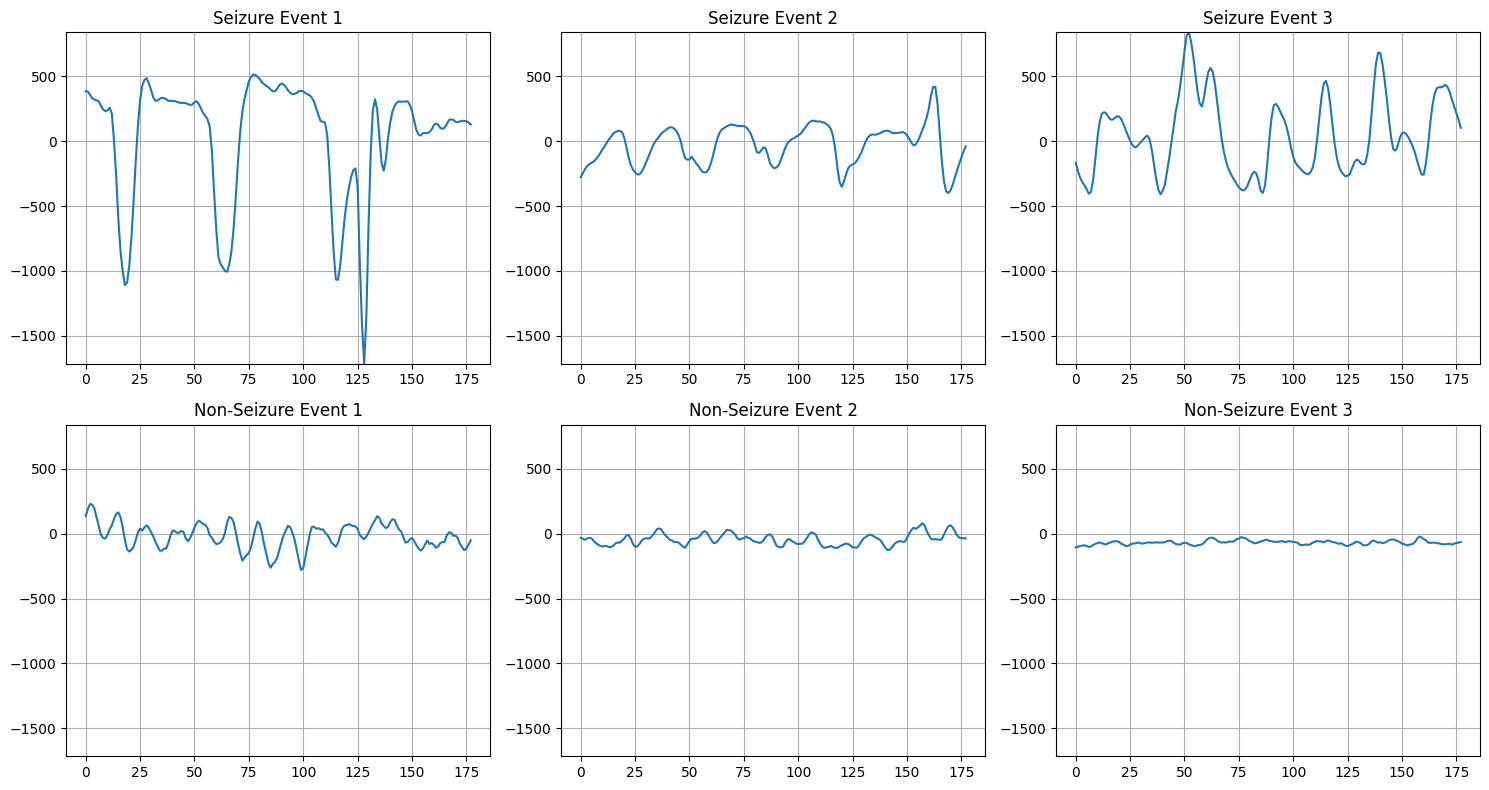

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# Extract labels and features
train_labels = train_data.iloc[:, -1].values
train_data = train_data.iloc[:, 1:-1].values

# Convert seizure events to binary classes (1 - Seizure, 0 - Non-Seizure)
train_labels = np.where(train_labels == 1, 1, 0)

# Get indices for seizure (label = 1) and non-seizure (label = 0) events
seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

# Select 3 random seizure and non-seizure events
random_seizure_samples = seizure_indices[:3]  # Taking first 3 seizure samples
random_non_seizure_samples = non_seizure_indices[:3]  # Taking first 3 non-seizure samples

# Find global y limits across all signals for consistent scaling
all_samples = np.concatenate([train_data[random_seizure_samples], train_data[random_non_seizure_samples]])
y_min, y_max = np.min(all_samples), np.max(all_samples)

# Plot 3 seizure events
plt.figure(figsize=(15, 8))

for i, idx in enumerate(random_seizure_samples, 1):
    plt.subplot(2, 3, i)
    plt.plot(train_data[idx])
    plt.title(f"Seizure Event {i}")
    plt.ylim([y_min, y_max])  # Set the same y-scale for all plots
    plt.grid(True)

# Plot 3 non-seizure events
for i, idx in enumerate(random_non_seizure_samples, 1):
    plt.subplot(2, 3, i+3)
    plt.plot(train_data[idx])
    plt.title(f"Non-Seizure Event {i}")
    plt.ylim([y_min, y_max])  # Set the same y-scale for all plots
    plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [13]:
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')
train_labels = train_data.iloc[:,-1]
train_labels = np.array(train_labels, dtype=np.int16)
feat_type = "DWT"    
standard_scaler = True 

if feat_type == "Time":
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   #train_data = sc.fit_transform(train_data)
elif feat_type == "DWT":
   dwt_base = "db4"
   dwt_dc_level = 3
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   print("Extracting DWT-based features\n")
   train_data = get_train_ft(train_data, dwt_base, dwt_dc_level)


train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure
n_lab = np.unique(train_labels)   
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

if standard_scaler:
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)


counts = []
for i in range(len(n_lab)):
    counts.append(np.sum(train_labels==i))
counts = counts/sum(counts)

print(f"Train data labels distributions: {counts*100}\n")

Extracting DWT-based features

Train data labels distributions: [80.14276444 19.85723556]



In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# Load and preprocess data
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')
train_labels = train_data.iloc[:, -1]
train_labels = np.array(train_labels, dtype=np.int16)
feat_type = "DWT"
standard_scaler = True

# Extract features based on the feature type
if feat_type == "Time":
    train_data = train_data.iloc[:, 1:-1]
    train_data = np.array(train_data)
elif feat_type == "DWT":
    dwt_base = "db4"
    dwt_dc_level = 3
    train_data = train_data.iloc[:, 1:-1]
    train_data = np.array(train_data)
    print("Extracting DWT-based features\n")
    handcrafted_features = get_train_ft(train_data, dwt_base, dwt_dc_level)

# Reload the original dataset to combine columns [1:n-1] with the handcrafted features
original_data = pd.read_csv('Epileptic Seizure Recognition.csv')
columns_to_combine = original_data.iloc[:, 1:-1].values  # Extract columns 1 to n-1
combined_train_data = np.hstack((columns_to_combine, handcrafted_features))  # Combine original and handcrafted features

# Convert labels to binary (1: seizure, 0: no seizure)
train_labels[train_labels != 1] = 0  # 1 - seizure, 0 - no seizure
n_lab = np.unique(train_labels)

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(combined_train_data, train_labels, test_size=0.33, random_state=42)

# Optionally scale data
if standard_scaler:
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)

# Calculate class distributions in the training data
counts = []
for i in range(len(n_lab)):
    counts.append(np.sum(train_labels == i))
counts = counts / sum(counts)

# Print class distribution
print(train_data.shape)
print(f"Train data labels distributions: {counts * 100}\n")


Extracting DWT-based features

(7705, 230)
Train data labels distributions: [80.14276444 19.85723556]



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 230, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 230, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 230, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,361 (403.75 KB)

 Trainable params: 103,361 (403.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8702 - loss: 0.4016 - val_accuracy: 0.9313 - val_loss: 0.2357
Epoch 2/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9665 - loss: 0.0963 - val_accuracy: 0.9728 - val_loss: 0.0672
Epoch 3/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.9680 - loss: 0.0868 - val_accuracy: 0.9585 - val_loss: 0.0912
Epoch 4/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9732 - loss: 0.0724 - val_accuracy: 0.9637 - val_loss: 0.0758
Epoch 5/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9783 - loss: 0.0597 - val_accuracy: 0.9663 - val_loss: 0.0763
Epoch 6/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9781 - loss: 0.0556 - val_accuracy: 0.9715 - val_loss: 0.0726
Epoch 7/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9794 - loss: 0.0566 - val_accuracy: 0.9715 - val_loss: 0.0518
Epoch 8/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9795 - loss: 0.0513 - va

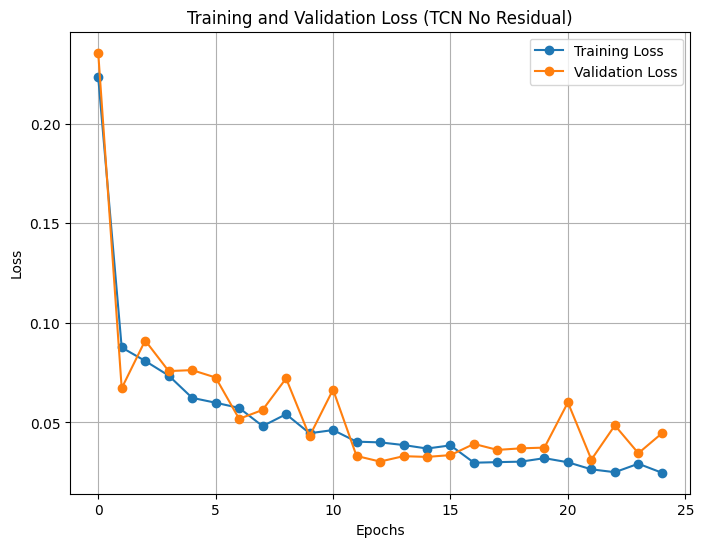

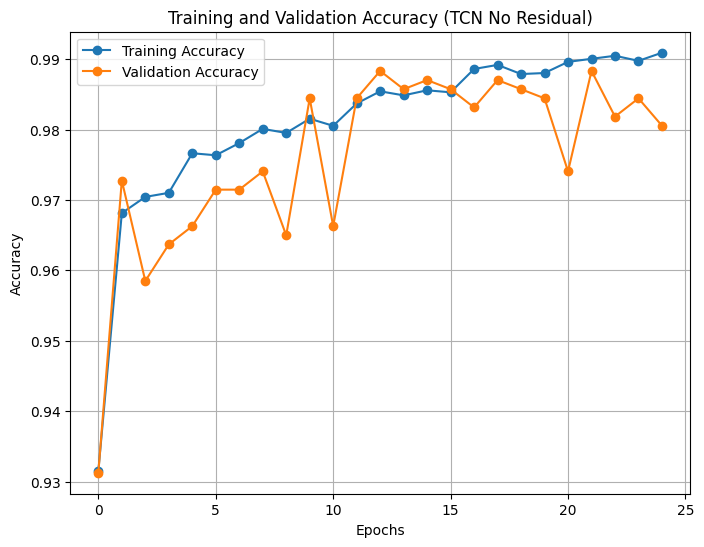

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9886 - loss: 0.0292
Test accuracy (TCN No Residual): 98.76%
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Classification Report (TCN No Residual):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.96      0.98      0.97       770

    accuracy                           0.99      3795
   macro avg       0.98      0.98      0.98      3795
weighted avg       0.99      0.99      0.99      3795



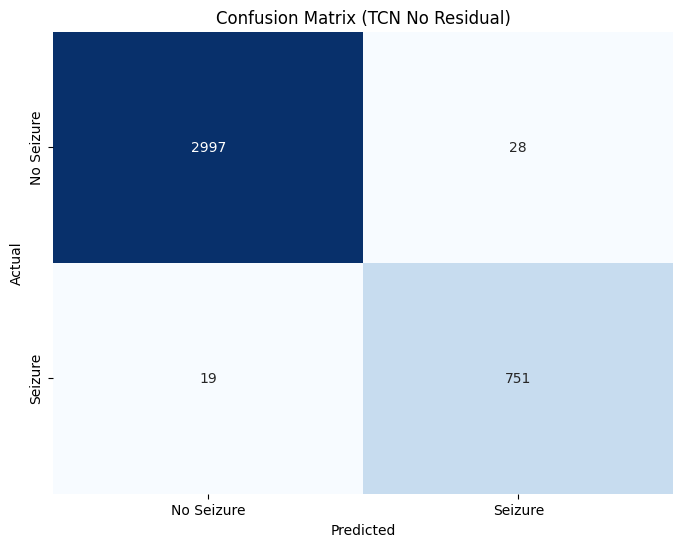

In [6]:
from tensorflow.keras import layers, models, initializers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def create_tcn_no_residual(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model without residual connections.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of convolutional blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Update x to the output of the current block
        x = conv2
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]  # (timesteps, features)


# Create TCN model without residual connections
tcn_model_no_residual = create_tcn_no_residual(input_shape)

# Compile the model
tcn_model_no_residual.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model_no_residual.summary()

# Train the model
history_no_residual = tcn_model_no_residual.fit(train_data, train_labels, epochs=25, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history_no_residual.history['loss'], label='Training Loss', marker='o')
plt.plot(history_no_residual.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN No Residual)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_no_residual.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_no_residual.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN No Residual)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss_no_residual, test_acc_no_residual = tcn_model_no_residual.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN No Residual): {test_acc_no_residual*100:.2f}%')

# Predict on test data
predictions_no_residual = tcn_model_no_residual.predict(test_data)
predictions_binary_no_residual = (predictions_no_residual > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN No Residual):")
print(classification_report(test_labels, predictions_binary_no_residual))

# Confusion Matrix
conf_matrix_no_residual = confusion_matrix(test_labels, predictions_binary_no_residual)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_no_residual, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN No Residual)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 230, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 230, 32)   │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 115, 32)   │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 115, 64)   │      6,208 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 57, 64)    │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 57, 64)    │     12,352 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 57, 64)    │          0 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 57, 64)    │     12,352 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 57, 64)    │          0 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 57, 64)    │          0 │ max_pooling1d_5[… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 57, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 57, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 57, 64)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 57, 64)    │     12,352 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 57, 64)    │          0 │ conv1d_17[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 57, 64)    │          0 │ activation[0][0], │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 57, 64)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 57, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 57, 64)    │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 57, 64)    │     12,352 │ dropout_12[0][0]

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8804 - loss: 0.3145 - val_accuracy: 0.9754 - val_loss: 0.0669
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9731 - loss: 0.0822 - val_accuracy: 0.9780 - val_loss: 0.0593
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9833 - loss: 0.0557 - val_accuracy: 0.9792 - val_loss: 0.0452
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9781 - loss: 0.0603 - val_accuracy: 0.9702 - val_loss: 0.0706
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9838 - loss: 0.0433 - val_accuracy: 0.9870 - val_loss: 0.0358
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9854 - loss: 0.0460 - val_accuracy: 0.9767 - val_loss: 0.0510
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9814 - loss: 0.0479 - val_accuracy: 0.9883 - val_loss: 0.0346
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9862 - loss: 0.0373 - val_accu

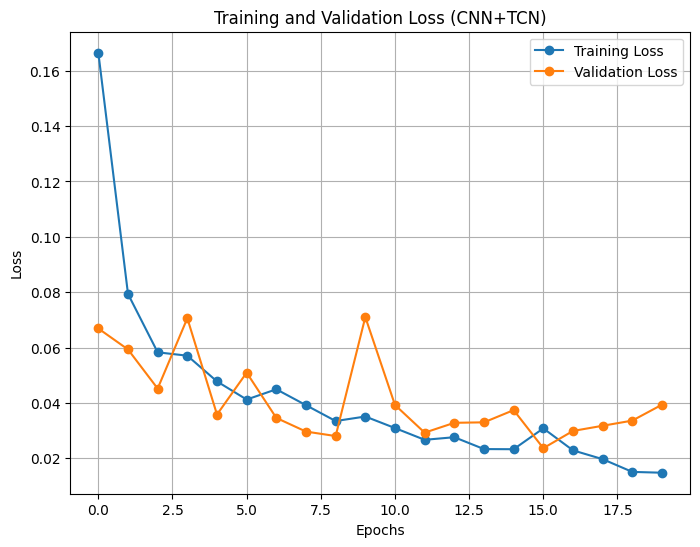

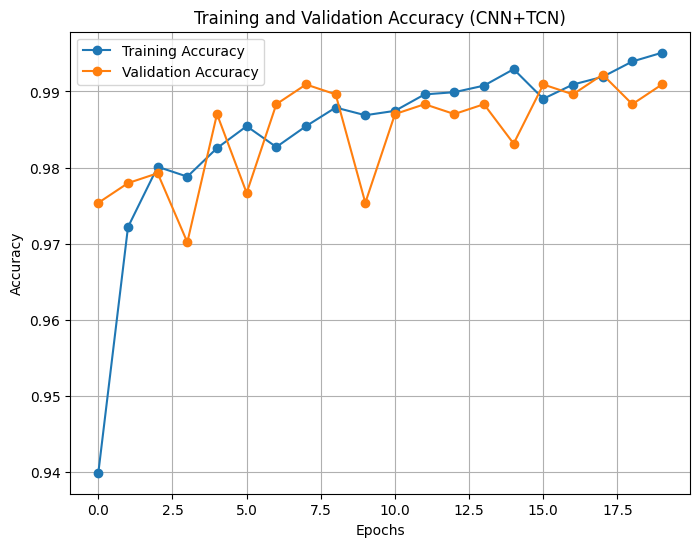

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9905 - loss: 0.0318
Test accuracy (CNN+TCN): 98.95%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.97      0.98      0.97       770

    accuracy                           0.99      3795
   macro avg       0.98      0.99      0.98      3795
weighted avg       0.99      0.99      0.99      3795



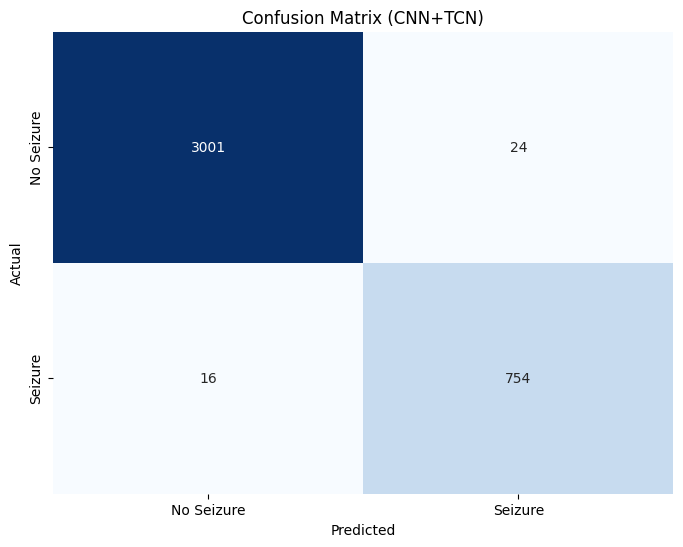

In [8]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1D-CNN MODEL

(7705, 230, 1)


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 228, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 114, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 112, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 56, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 23, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,353 (923.25 KB)

 Trainable params: 236,353 (923.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8970 - loss: 0.2593 - val_accuracy: 0.9598 - val_loss: 0.1081
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9602 - loss: 0.0935 - val_accuracy: 0.9663 - val_loss: 0.0697
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9764 - loss: 0.0665 - val_accuracy: 0.9741 - val_loss: 0.0526
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9785 - loss: 0.0545 - val_accuracy: 0.9805 - val_loss: 0.0454
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9876 - loss: 0.0375 - val_accuracy: 0.9844 - val_loss: 0.0365
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9873 - loss: 0.0375 - val_accuracy: 0.9585 - val_loss: 0.0993
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9872 - loss: 0.0381 - val_accuracy: 0.9818 - val_loss: 0.0446
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9874 - loss: 0.0324 - val_accu

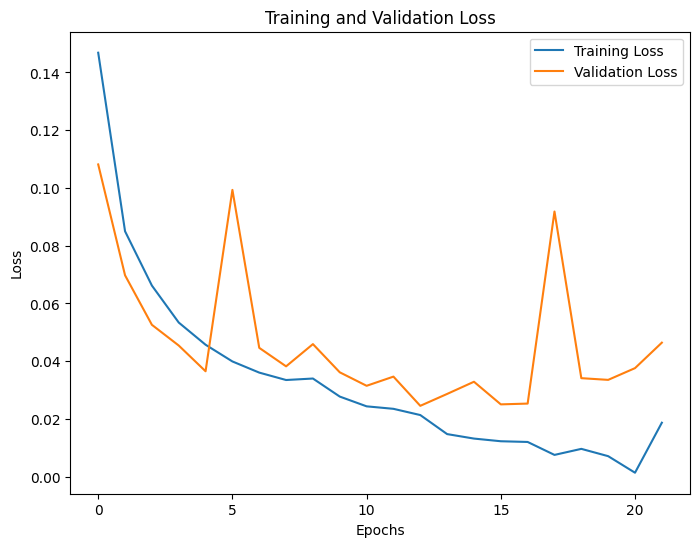

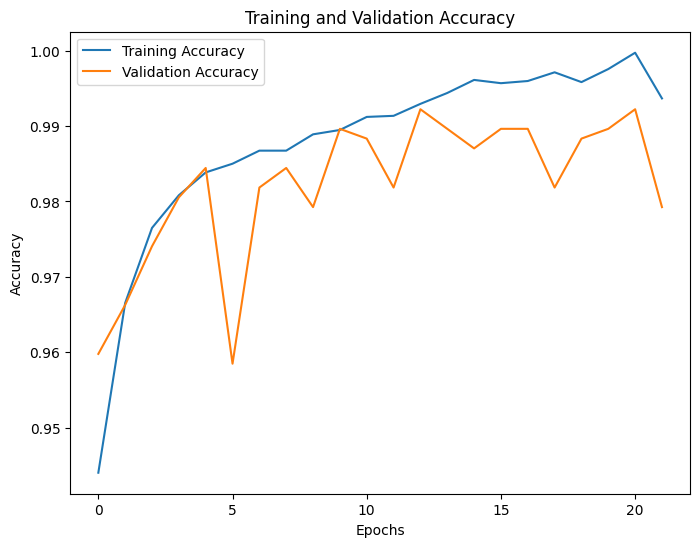

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9813 - loss: 0.0489
Test accuracy (CNN): 98.18181991577148%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       0.98      0.93      0.95       770

    accuracy                           0.98      3795
   macro avg       0.98      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



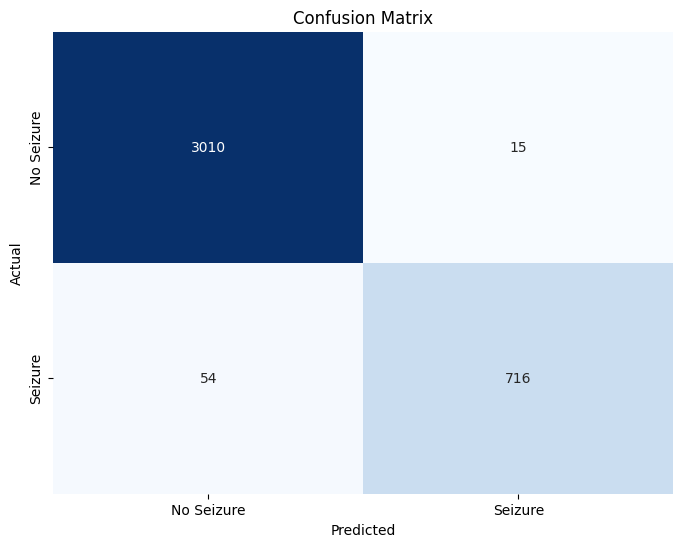

In [13]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=5, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model

print(train_data.shape)
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from tensorflow.keras import layers, models, Input

def create_combined_cnn(input_shape_raw, input_shape_handcrafted):
    # Input 1: Raw EEG signal data
    raw_input = Input(shape=input_shape_raw)
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(raw_input)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(256, kernel_size=5, activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)

    # Input 2: Handcrafted features input
    handcrafted_input = Input(shape=input_shape_handcrafted)
    y = layers.Dense(64, activation='relu')(handcrafted_input)
    y = layers.Dense(32, activation='relu')(y)

    # Combine both inputs
    combined = layers.concatenate([x, y])

    # Output layers
    z = layers.Dense(128, activation='relu')(combined)
    z = layers.Dense(64, activation='relu')(z)
    output = layers.Dense(1, activation='sigmoid')(z)

    # Create the model
    model = models.Model(inputs=[raw_input, handcrafted_input], outputs=output)
    return model


RANDOM FOREST MODEL

In [1]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



NameError: name 'train_data' is not defined

In [37]:
import matplotlib.pyplot as plt

accuracy_scores = [knn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy,adaboost_accuracy, test_acc_cnn,test_acc_lstm,ensemble_accuracy]
classifier_names = ['KNN', 'SVM', 'DCT', 'RF', 'ADA', 'CNN','LSTM','CNN+LSTM']

plt.figure(figsize=(12, 7)) 
bars = plt.bar(classifier_names, accuracy_scores, color=['purple', 'blue', 'red', 'green', 'lavender', 'orange', 'pink','yellow'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)  

for bar, label in zip(bars, accuracy_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(label, 2), ha='center', va='bottom')

plt.show()

NameError: name 'test_acc_cnn' is not defined

In [ ]:
DIRECTLY USING THE SIGNAL DATA INSTEAD OF FEATURE EXTRACTION AND COMPARE

In [5]:
# Load the dataset
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# Extract labels (assuming the last column contains the labels)
train_labels = train_data.iloc[:, -1].values
train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure

# Drop the first column and the label column from the features
train_data = train_data.iloc[:, 1:-1].values

# Split the data into 67% training and 33% testing
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data, train_labels, test_size=0.33, random_state=42)

# Print the shapes of the resulting datasets
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train data shape: (7705, 178)
Test data shape: (3795, 178)
Train labels shape: (7705,)
Test labels shape: (3795,)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ....................................n_estimators=50; total time=   4.0s
[CV] END ....................................n_estimators=50; total time=   3.4s
[CV] END ....................................n_estimators=50; total time=   3.2s
[CV] END ....................................n_estimators=50; total time=   3.4s
[CV] END ....................................n_estimators=50; total time=   3.3s
[CV] END ...................................n_estimators=100; total time=   7.1s
[CV] END ...................................n_estimators=100; total time=   7.1s
[CV] END ...................................n_estimators=100; total time=   6.5s
[CV] END ...................................n_estimators=100; total time=   6.4s
[CV] END ...................................n_estimators=100; total time=   6.4s
[CV] END ...................................n_estimators=200; total time=  13.2s
[CV] END ...................................n_est

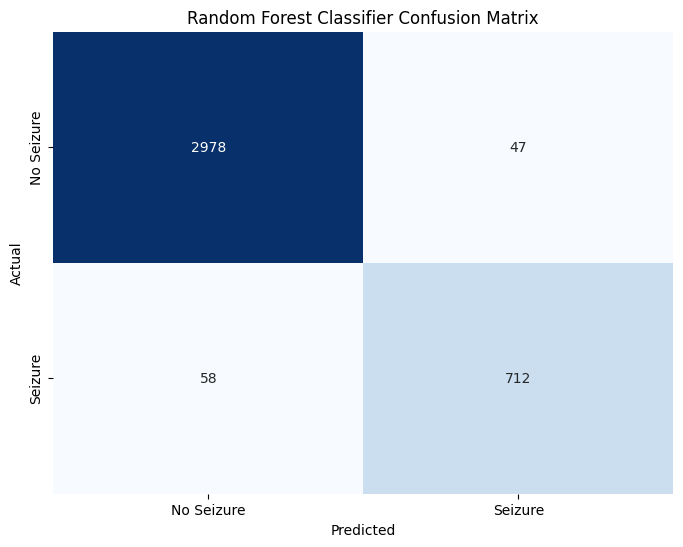

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape train and test data
train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)

# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500]  # Different numbers of trees to test
}

# Initialize the RandomForestClassifier
random_forest_classifier = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=random_forest_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

# Fit the model with training data
grid_search.fit(train_data_reshaped, train_labels)

# Print the best parameters and the best accuracy score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_}")

# Evaluate the best model on the test data
best_rf_model = grid_search.best_estimator_
predictions = best_rf_model.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))

# Plot the confusion matrix
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/home/rakesh018/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 94.2292490118577%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3025
           1       0.89      0.82      0.85       770

    accuracy                           0.94      3795
   macro avg       0.92      0.90      0.91      3795
weighted avg       0.94      0.94      0.94      3795



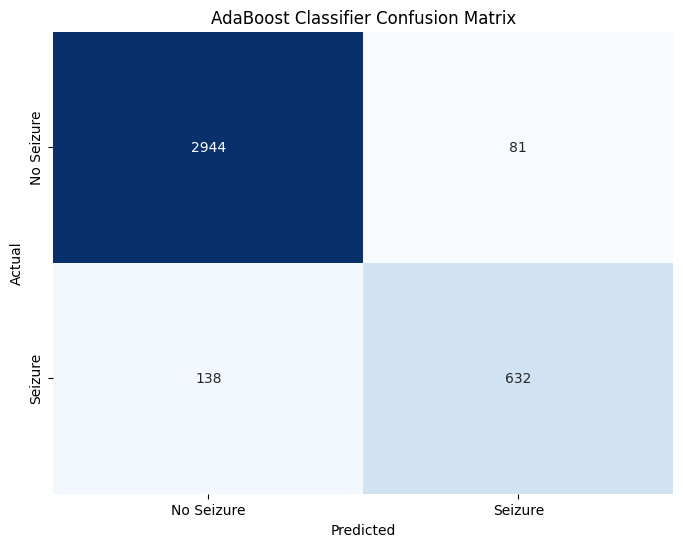

In [44]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM Classifier Test Accuracy: 97.23320158102767%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.96      0.90      0.93       770

    accuracy                           0.97      3795
   macro avg       0.97      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



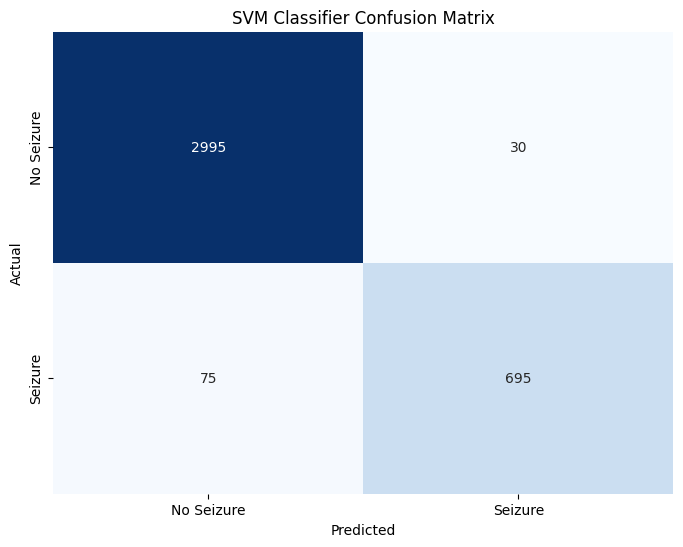

In [45]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN Classifier Accuracy: 91.9631093544137%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3025
           1       0.99      0.61      0.75       770

    accuracy                           0.92      3795
   macro avg       0.95      0.80      0.85      3795
weighted avg       0.93      0.92      0.91      3795



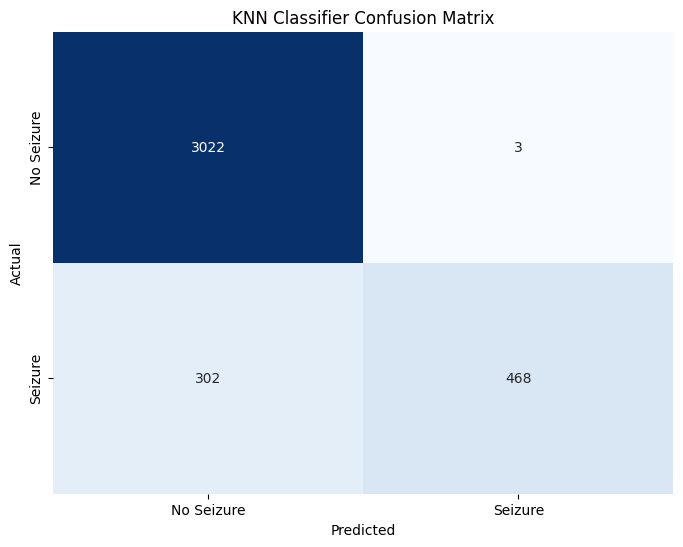

In [39]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/22


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7144 - loss: 0.6691 - val_accuracy: 0.9209 - val_loss: 0.3070
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9449 - loss: 0.1893 - val_accuracy: 0.9844 - val_loss: 0.0732
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9793 - loss: 0.0603 - val_accuracy: 0.9702 - val_loss: 0.0738
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.9857 - val_loss: 0.0674
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9821 - loss: 0.0512 - val_accuracy: 0.9857 - val_loss: 0.0378
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9877 - loss: 0.0422 - val_accuracy: 0.9883 - val_loss: 0.0354
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9885 - loss: 0.0304 - val_accuracy: 0.9831 - val_loss: 0.0615
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.9844 - val_

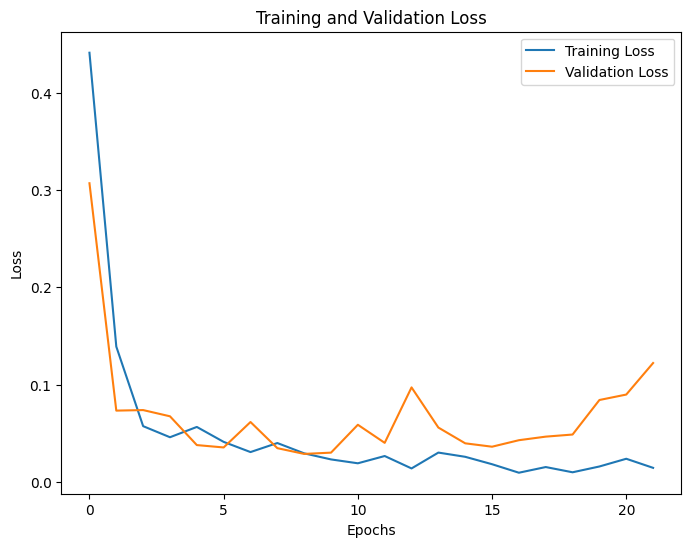

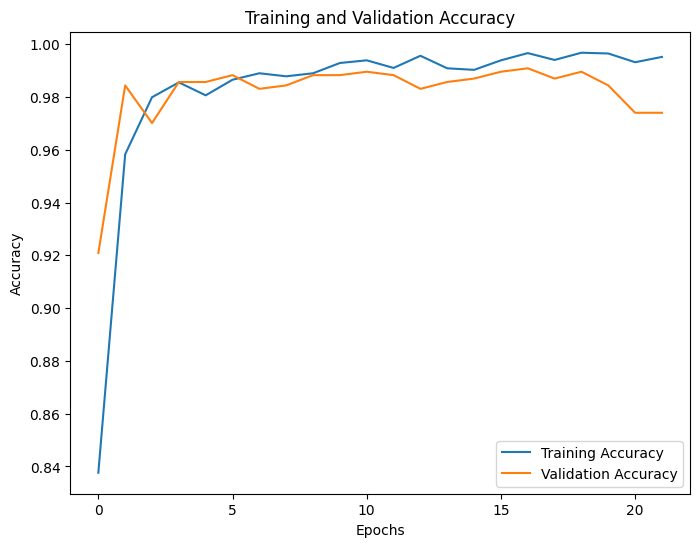

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0627
Test accuracy (CNN): 98.36627244949341%
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       0.99      0.92      0.96       770

    accuracy                           0.98      3795
   macro avg       0.99      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



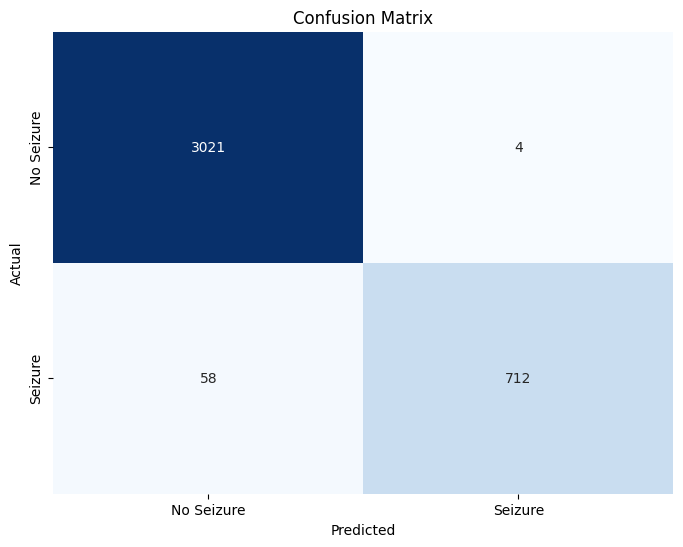

In [49]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=7, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 178, 64)   │        256 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 178, 64)   │          0 │ conv1d_33[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 178, 64)   │     12,352 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 178, 64)   │        128 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 178, 64)   │          0 │ conv1d_34[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 178, 64)   │          0 │ conv1d_35[0][0],  │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 178, 64)   │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 178, 64)   │     12,352 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 178, 64)   │          0 │ conv1d_36[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 178, 64)   │     12,352 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 178, 64)   │          0 │ conv1d_37[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 178, 64)   │          0 │ activation_12[0]… │
│                     │                   │            │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 178, 64)   │          0 │ add_13[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 178, 64)   │     12,352 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 178, 64)   │          0 │ conv1d_38[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 178, 64)   │     12,352 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 178, 64)   │          0 │ conv1d_39[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 178, 64)   │          0 │ activation_13[0]… │
│                     │                   │            │ dropout_29[0][0]

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5663 - loss: 61.7899 - val_accuracy: 0.6161 - val_loss: 0.8020
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8540 - loss: 0.4650 - val_accuracy: 0.9261 - val_loss: 0.2870
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9026 - loss: 0.3511 - val_accuracy: 0.8703 - val_loss: 0.3382
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9192 - loss: 0.2566 - val_accuracy: 0.9663 - val_loss: 0.1597
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9367 - loss: 0.2154 - val_accuracy: 0.9429 - val_loss: 0.1858
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9556 - loss: 0.1604 - val_accuracy: 0.9364 - val_loss: 0.2315
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9639 - loss: 0.1393 - val_accuracy: 0.9624 - val_loss: 0.1146
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9641 - loss: 0.1286 - val_ac

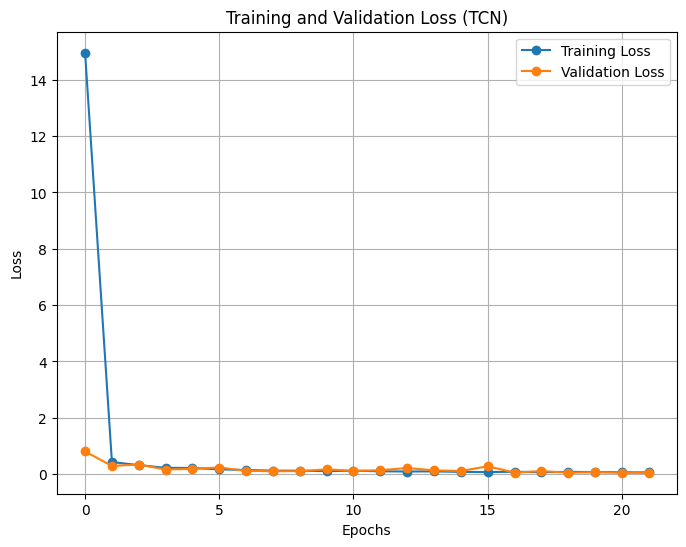

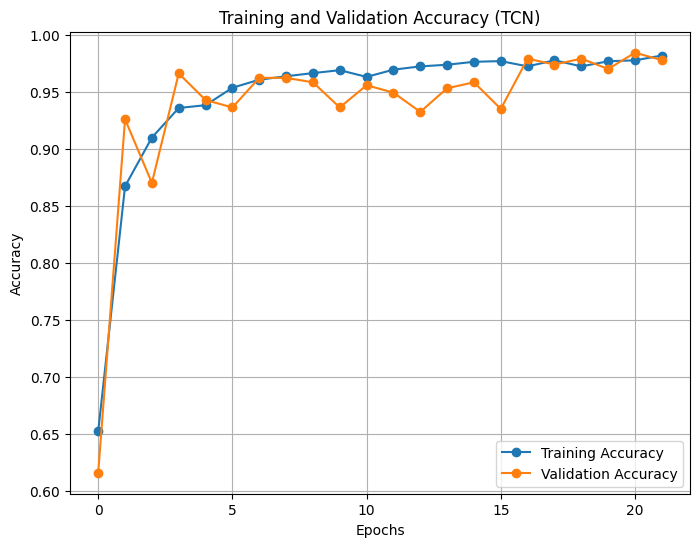

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9815 - loss: 0.0521
Test accuracy (TCN): 98.18%
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Classification Report (TCN):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3025
           1       0.98      0.93      0.95       770

    accuracy                           0.98      3795
   macro avg       0.98      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



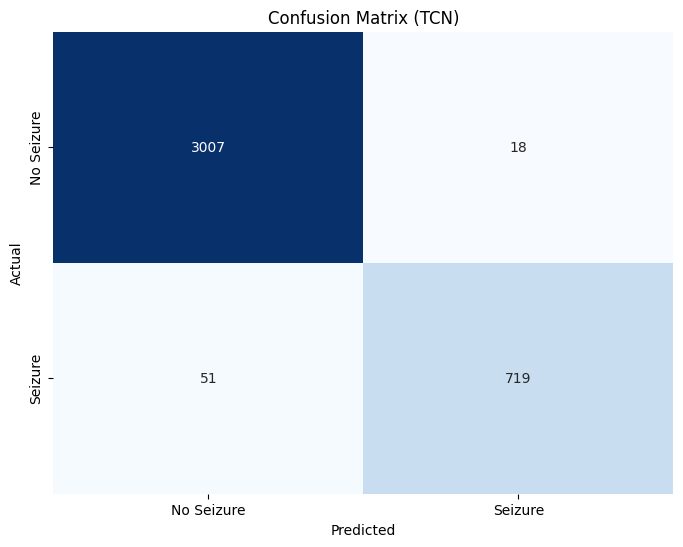

Model saved as 'TCN_178.h5'


In [11]:
# Reshape data for TCN model
from tensorflow.keras import initializers, models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of residual blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the residual block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the residual block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Residual connection
        if x.shape[-1] != conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, conv2])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create TCN model
tcn_model = create_tcn(input_shape)

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model.summary()

# Train the model
history = tcn_model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_tcn = tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN): {test_acc_tcn*100:.2f}%')

# Predict on test data
predictions = tcn_model.predict(test_data)
predictions_binary = (predictions > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the model
tcn_model.save('TCN_178.h5')
print("Model saved as 'TCN_178.h5'")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 178, 32)   │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 89, 32)    │          0 │ conv1d_23[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 89, 64)    │      6,208 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 44, 64)    │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 44, 64)    │     12,352 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 44, 64)    │          0 │ conv1d_25[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 44, 64)    │          0 │ conv1d_26[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 44, 64)    │          0 │ max_pooling1d_7[… │
│                     │                   │            │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 44, 64)    │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 44, 64)    │          0 │ conv1d_27[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 44, 64)    │          0 │ conv1d_28[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 44, 64)    │          0 │ activation_8[0][… │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 44, 64)    │          0 │ add_9[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 44, 64)    │          0 │ conv1d_29[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.7185 - loss: 3.3271 - val_accuracy: 0.9377 - val_loss: 0.2971
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9548 - loss: 0.2117 - val_accuracy: 0.9624 - val_loss: 0.1531
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9699 - loss: 0.1090 - val_accuracy: 0.9870 - val_loss: 0.0487
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9752 - loss: 0.0807 - val_accuracy: 0.9546 - val_loss: 0.1251
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9751 - loss: 0.0652 - val_accuracy: 0.9896 - val_loss: 0.0298
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9810 - loss: 0.0566 - val_accuracy: 0.9844 - val_loss: 0.0378
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9827 - loss: 0.0423 - val_accuracy: 0.9909 - val_loss: 0.0272
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9826 - loss: 0.0480 - val_accu

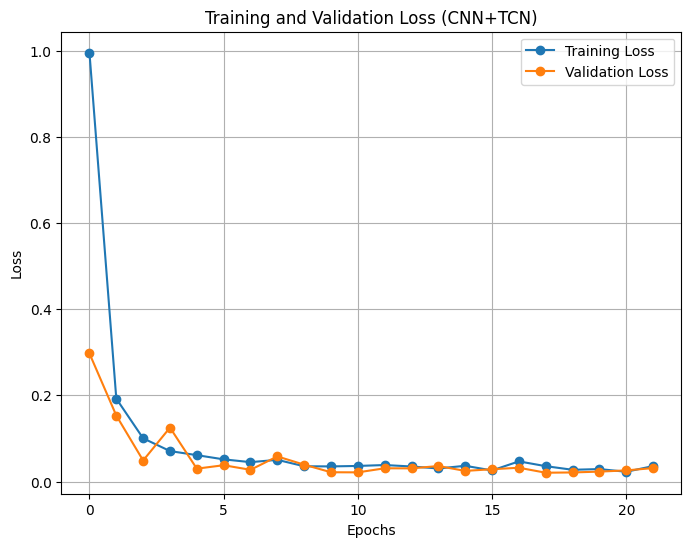

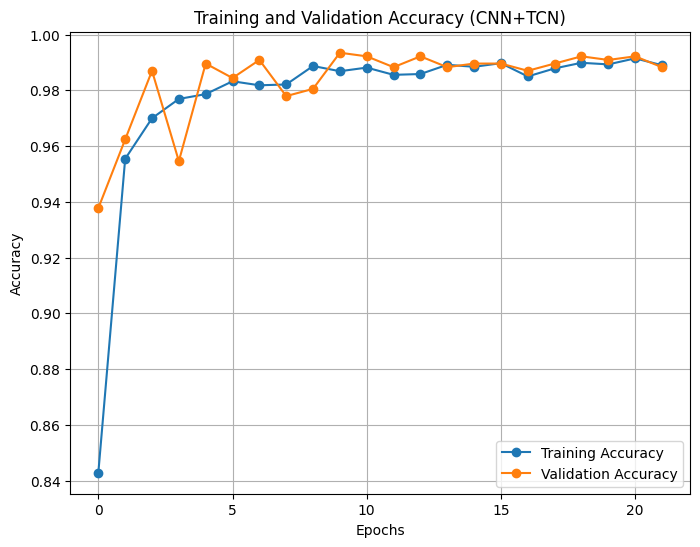

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9862 - loss: 0.0370
Test accuracy (CNN+TCN): 98.63%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.97      0.96      0.97       770

    accuracy                           0.99      3795
   macro avg       0.98      0.98      0.98      3795
weighted avg       0.99      0.99      0.99      3795



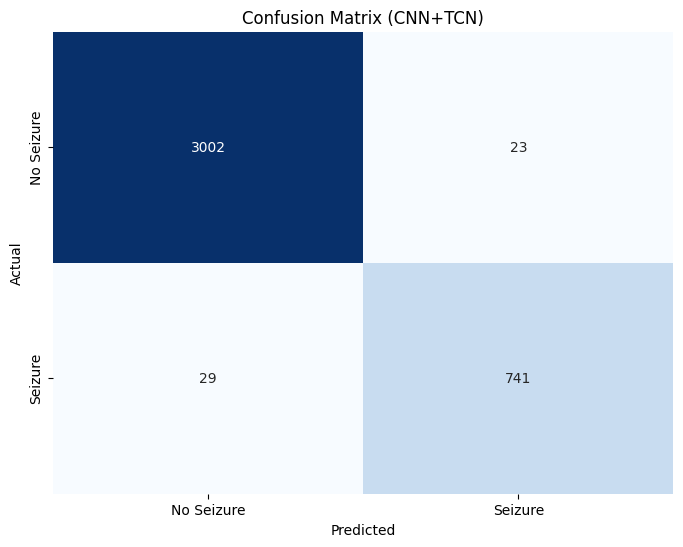

In [10]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()